# Early Cardiovascular Risk Prediction

### Clinical Decision Support System using Random Forest



## Introducción

La enfermedad cardiovascular representa una de las principales causas de morbilidad y mortalidad a nivel mundial. La identificación temprana de pacientes con mayor riesgo permite implementar estrategias preventivas y de seguimiento oportunas.

En este proyecto se desarrolla un modelo de aprendizaje automático orientado a la predicción temprana de riesgo cardiovascular, utilizando variables clínicas de uso habitual. Se prioriza no solo el desempeño predictivo, sino también la interpretabilidad clínica y la robustez del modelo.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

## Dataset

El dataset utilizado contiene información clínica de pacientes adultos, incluyendo variables demográficas, antropométricas, hábitos de vida y mediciones de presión arterial. La variable objetivo indica la presencia o ausencia de enfermedad cardiovascular.

In [3]:
df = pd.read_csv("cardio_train.csv", sep=";")
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### Exploración inicial de datos (EDA)

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


## Procesamiento de Datos

### Edad e IMC

Antes del entrenamiento del modelo, se realizó un proceso de ingeniería de variables guiado por criterios clínicos. El objetivo fue mejorar la calidad de la señal predictiva y asegurar que las variables reflejen conceptos médicos relevantes, en lugar de depender exclusivamente del aprendizaje automático.

In [5]:
# ------- Edad -------
# Convertimos edad de días a años
df["age_years"] = (df["age"] / 365.25).astype(int)

# Creamos grupos etarios clínicamente relevantes
def age_group(age):
    if age < 40:
        return "young_adult"
    elif age < 60:
        return "middle_age"
    else:
        return "older_adult"

df["age_group"] = df["age_years"].apply(age_group)

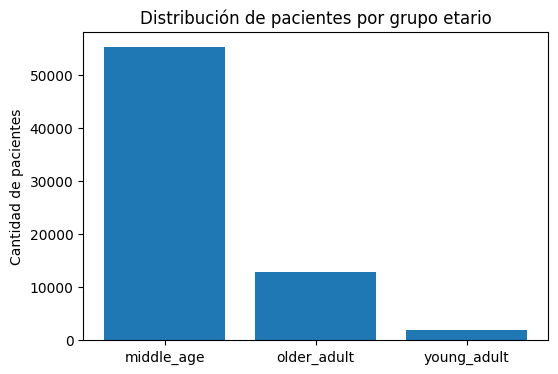

In [6]:
# Conteo de pacientes por grupo etario
age_counts = df["age_group"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(age_counts.index, age_counts.values)
plt.ylabel("Cantidad de pacientes")
plt.title("Distribución de pacientes por grupo etario")
plt.show()

In [7]:
# ------- IMC -------
# Altura en metros
df["height_m"] = df["height"] / 100

# Índice de Masa Corporal
df["bmi"] = df["weight"] / (df["height_m"] ** 2)

# Categorías clínicas de IMC
def bmi_category(bmi):
    if bmi < 18.5:
        return "underweight"
    elif bmi < 25:
        return "normal"
    elif bmi < 30:
        return "overweight"
    else:
        return "obese"

df["bmi_category"] = df["bmi"].apply(bmi_category)


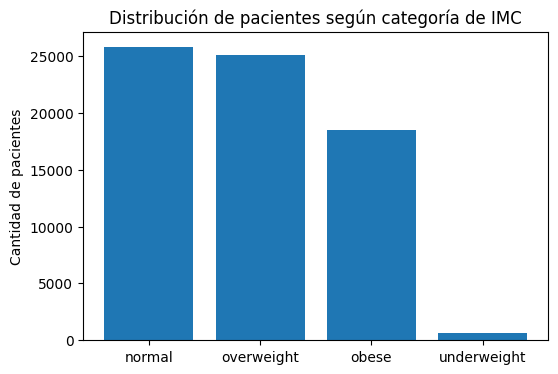

In [8]:
# Conteo por categoría de IMC
bmi_counts = df["bmi_category"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(bmi_counts.index, bmi_counts.values)
plt.ylabel("Cantidad de pacientes")
plt.title("Distribución de pacientes según categoría de IMC")
plt.show()

In [9]:
# Verificamos las nuevas variables
df[["age", "age_years", "age_group", "height", "weight", "bmi", "bmi_category"]].head()

,age,age_years,age_group,height,weight,bmi,bmi_category
0,18393,50,middle_age,168,62.0,21.967120,normal
1,20228,55,middle_age,156,85.0,34.927679,obese
2,18857,51,middle_age,165,64.0,23.507805,normal
3,17623,48,middle_age,169,82.0,28.710479,overweight
4,17474,47,middle_age,156,56.0,23.011177,normal


### Presión arterial

In [10]:
# ------- Detectar valores fuera de rangos posible -------
# Usamos umbrales razonables basados en fisiología humana normal
# Presión sistólica típica: 60–250 mm Hg
# Presión diastólica típica: 40–150 mm Hg

df = df[
    (df["ap_hi"].between(60, 250)) &
    (df["ap_lo"].between(40, 150))
].copy()


In [11]:
# ------- Categorizar presión arterial usando criterios clínicos -------
def bp_category(sys, dia):
    # Basado en rangos clínicos de presión arterial
    # Normal: <120/<80
    # Elevada: 120–129/<80
    # Hipertensión etapa 1: 130–139/80–89
    # Hipertensión etapa 2: >=140/>=90
    if (sys < 120) and (dia < 80):
        return "bp_normal"
    elif (120 <= sys < 130) and (dia < 80):
        return "bp_elevated"
    elif (130 <= sys < 140) or (80 <= dia < 90):
        return "bp_hypertension_stage1"
    else:
        return "bp_hypertension_stage2"

df["bp_category"] = df.apply(lambda x: bp_category(x["ap_hi"], x["ap_lo"]), axis=1)



In [12]:
# 3) Presión de pulso (sistólica – diastólica): señal clínica
df["pulse_pressure"] = df["ap_hi"] - df["ap_lo"]



In [13]:
# Verificamos cómo quedaron las nuevas variables
df[["ap_hi", "ap_lo", "bp_category", "pulse_pressure"]].head()

,ap_hi,ap_lo,bp_category,pulse_pressure
0,110,80,bp_hypertension_stage1,30
1,140,90,bp_hypertension_stage2,50
2,130,70,bp_hypertension_stage1,60
3,150,100,bp_hypertension_stage2,50
4,100,60,bp_normal,40


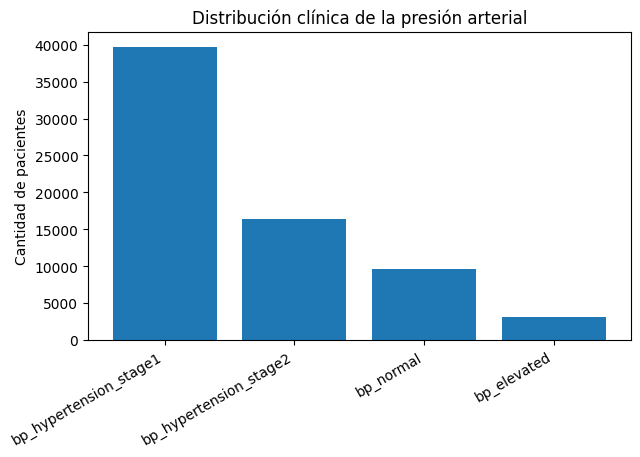

In [14]:
# Conteo por categoría de presión arterial
bp_counts = df["bp_category"].value_counts()

plt.figure(figsize=(7,4))
plt.bar(bp_counts.index, bp_counts.values)
plt.ylabel("Cantidad de pacientes")
plt.title("Distribución clínica de la presión arterial")
plt.xticks(rotation=30, ha="right")
plt.show()


## Relación con la variable objetivo (cardio)
¿Las categorías clínicas que construimos muestran mayor prevalencia de enfermedad cardiovascular?

Los análisis exploratorios muestran una relación consistente entre las variables clínicas diseñadas y la presencia de enfermedad cardiovascular. Se observa un aumento progresivo del riesgo a medida que se incrementa la severidad clínica de los factores analizados, lo cual concuerda con la evidencia médica conocida.

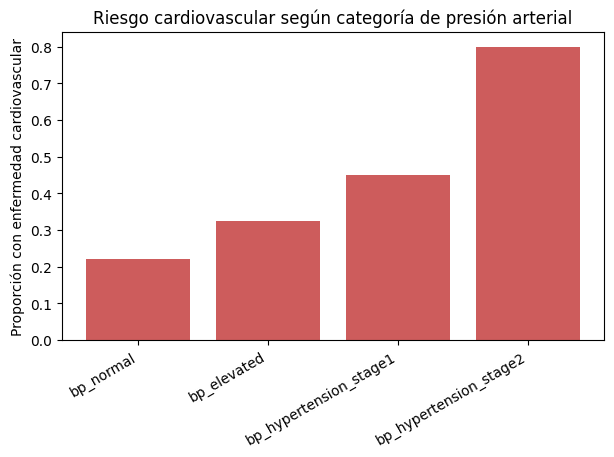

In [15]:
bp_order = [
    "bp_normal",
    "bp_elevated",
    "bp_hypertension_stage1",
    "bp_hypertension_stage2"
]

bp_cardio_rate = (
    df.groupby("bp_category")["cardio"]
    .mean()
    .reindex(bp_order)
)

plt.figure(figsize=(7,4))
plt.bar(bp_cardio_rate.index, bp_cardio_rate.values, color="indianred")
plt.ylabel("Proporción con enfermedad cardiovascular")
plt.title("Riesgo cardiovascular según categoría de presión arterial")
plt.xticks(rotation=30, ha="right")
plt.show()


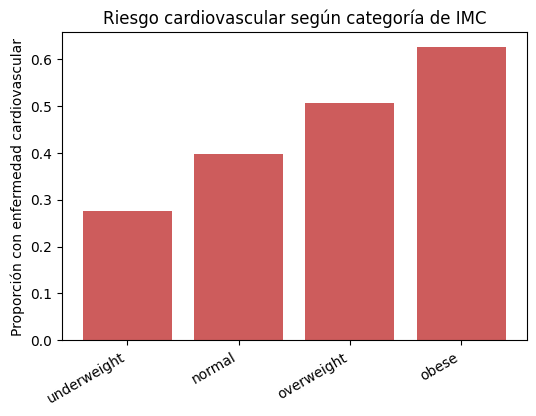

In [16]:
bmi_order = ["underweight", "normal", "overweight", "obese"]

bmi_cardio_rate = (
    df.groupby("bmi_category")["cardio"]
    .mean()
    .reindex(bmi_order)
)

plt.figure(figsize=(6,4))
plt.bar(bmi_cardio_rate.index, bmi_cardio_rate.values, color="indianred")
plt.ylabel("Proporción con enfermedad cardiovascular")
plt.title("Riesgo cardiovascular según categoría de IMC")
plt.xticks(rotation=30, ha="right")
plt.show()


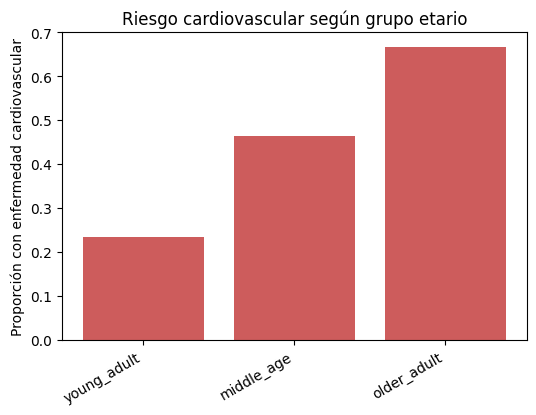

In [17]:
age_order = [
    "young_adult",
    "middle_age",
    "older_adult"
]

age_cardio_rate = (
    df.groupby("age_group")["cardio"]
    .mean()
    .reindex(age_order)
)

plt.figure(figsize=(6,4))
plt.bar(age_cardio_rate.index, age_cardio_rate.values, color="indianred")
plt.ylabel("Proporción con enfermedad cardiovascular")
plt.title("Riesgo cardiovascular según grupo etario")
plt.xticks(rotation=30, ha="right")
plt.show()


In [18]:
df = df.drop(columns="id")


In [19]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 68755 entries, 0 to 69999
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             68755 non-null  int64  
 1   gender          68755 non-null  int64  
 2   height          68755 non-null  int64  
 3   weight          68755 non-null  float64
 4   ap_hi           68755 non-null  int64  
 5   ap_lo           68755 non-null  int64  
 6   cholesterol     68755 non-null  int64  
 7   gluc            68755 non-null  int64  
 8   smoke           68755 non-null  int64  
 9   alco            68755 non-null  int64  
 10  active          68755 non-null  int64  
 11  cardio          68755 non-null  int64  
 12  age_years       68755 non-null  int64  
 13  age_group       68755 non-null  object 
 14  height_m        68755 non-null  float64
 15  bmi             68755 non-null  float64
 16  bmi_category    68755 non-null  object 
 17  bp_category     68755 non-null  obje

In [20]:
df.head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,age_group,height_m,bmi,bmi_category,bp_category,pulse_pressure
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,middle_age,1.68,21.967120,normal,bp_hypertension_stage1,30
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,middle_age,1.56,34.927679,obese,bp_hypertension_stage2,50
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,middle_age,1.65,23.507805,normal,bp_hypertension_stage1,60
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,middle_age,1.69,28.710479,overweight,bp_hypertension_stage2,50
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,middle_age,1.56,23.011177,normal,bp_normal,40


### Encoding

Las variables categóricas clínicas fueron transformadas mediante one-hot encoding, preservando su interpretación médica y evitando la imposición de relaciones ordinales artificiales. Las variables numéricas se mantuvieron en su escala original.

In [21]:
df.dtypes


,0
age,int64
gender,int64
height,int64
weight,float64
ap_hi,int64
ap_lo,int64
cholesterol,int64
gluc,int64
smoke,int64
alco,int64


In [22]:
categorical_features = df.select_dtypes(include="object").columns.tolist()
categorical_features


['age_group', 'bmi_category', 'bp_category']

In [23]:
df_encoded = pd.get_dummies(
    df,
    columns=categorical_features,
    drop_first=True
)

In [24]:
df_encoded.info()
df_encoded.head()

<class 'pandas.core.frame.DataFrame'>
Index: 68755 entries, 0 to 69999
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 68755 non-null  int64  
 1   gender                              68755 non-null  int64  
 2   height                              68755 non-null  int64  
 3   weight                              68755 non-null  float64
 4   ap_hi                               68755 non-null  int64  
 5   ap_lo                               68755 non-null  int64  
 6   cholesterol                         68755 non-null  int64  
 7   gluc                                68755 non-null  int64  
 8   smoke                               68755 non-null  int64  
 9   alco                                68755 non-null  int64  
 10  active                              68755 non-null  int64  
 11  cardio                              68755 non-

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,bmi,pulse_pressure,age_group_older_adult,age_group_young_adult,bmi_category_obese,bmi_category_overweight,bmi_category_underweight,bp_category_bp_hypertension_stage1,bp_category_bp_hypertension_stage2,bp_category_bp_normal
0,18393,2,168,62.0,110,80,1,1,0,0,...,21.967120,30,False,False,False,False,False,True,False,False
1,20228,1,156,85.0,140,90,3,1,0,0,...,34.927679,50,False,False,True,False,False,False,True,False
2,18857,1,165,64.0,130,70,3,1,0,0,...,23.507805,60,False,False,False,False,False,True,False,False
3,17623,2,169,82.0,150,100,1,1,0,0,...,28.710479,50,False,False,False,True,False,False,True,False
4,17474,1,156,56.0,100,60,1,1,0,0,...,23.011177,40,False,False,False,False,False,False,False,True


### Definición de variables clínicas

In [25]:
X = df_encoded.drop(columns="cardio")
y = df_encoded["cardio"]


La variable objetivo (cardio) representa el diagnóstico de enfermedad cardiovascular. Las variables independientes corresponden a factores de riesgo clínicos.

### División Train / Test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Se utiliza una división 80/20 asegurando una distribución balanceada de clases, práctica recomendada en clasificación médica.

## Selección del modelo: Random Forest

Se seleccionó Random Forest como modelo principal debido a su capacidad para capturar relaciones no lineales, manejar interacciones entre variables y mantener una buena interpretabilidad en contextos clínicos. Se utilizó validación cruzada y AUC-ROC como métrica principal.

### Optimización de hiperparámetros (GridSearch)

In [27]:
rf = RandomForestClassifier(class_weight="balanced", random_state=42)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15],
    "min_samples_split": [20, 50],
    "min_samples_leaf": [5, 20],
    "criterion": ["gini", "entropy"]
}

grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15], 'min_samples_leaf': [5, 20],
                         'min_samples_split': [20, 50],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

Se prioriza AUC-ROC como métrica de optimización debido a su relevancia en escenarios de clasificación médica.

In [28]:
best_rf = grid.best_estimator_
best_rf

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_leaf=20, min_samples_split=50,
                       n_estimators=200, random_state=42)

## Evaluación del modelo
###Matriz de confusión + métricas relevantes

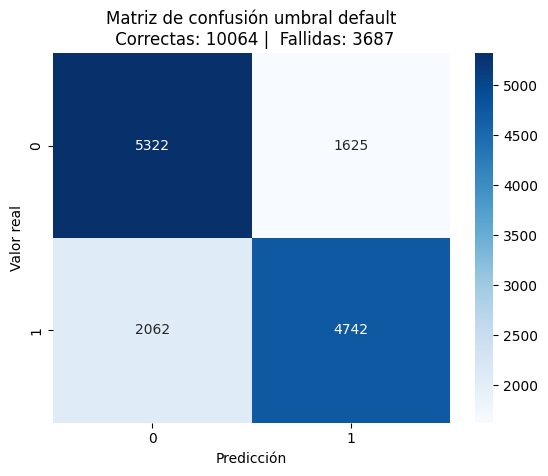

In [29]:
y_pred = best_rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

correctas = cm[0,0] + cm[1,1]
fallidas = cm[0,1] + cm[1,0]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title(f"Matriz de confusión umbral default\n Correctas: {correctas} |  Fallidas: {fallidas}")
plt.show()

In [30]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.77      0.74      6947
           1       0.74      0.70      0.72      6804

    accuracy                           0.73     13751
   macro avg       0.73      0.73      0.73     13751
weighted avg       0.73      0.73      0.73     13751



In [31]:
y_prob = best_rf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_prob)
auc

np.float64(0.7987149300485993)

### Curva ROC

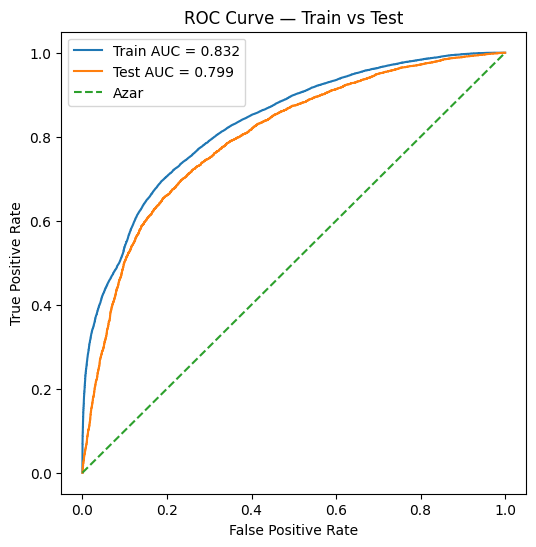

In [32]:
# ROC train
y_train_prob = best_rf.predict_proba(X_train)[:,1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
auc_train = roc_auc_score(y_train, y_train_prob)

# ROC test
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob)
auc_test = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.3f}")
plt.plot([0,1], [0,1], linestyle="--", label="Azar")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Train vs Test")
plt.legend()
plt.show()

El modelo mostró una adecuada capacidad de discriminación entre pacientes con y sin enfermedad cardiovascular. La comparación entre las curvas ROC de entrenamiento y prueba sugiere una buena generalización, sin evidencias claras de sobreajuste.

### Interpretabilidad: Importancia de variables

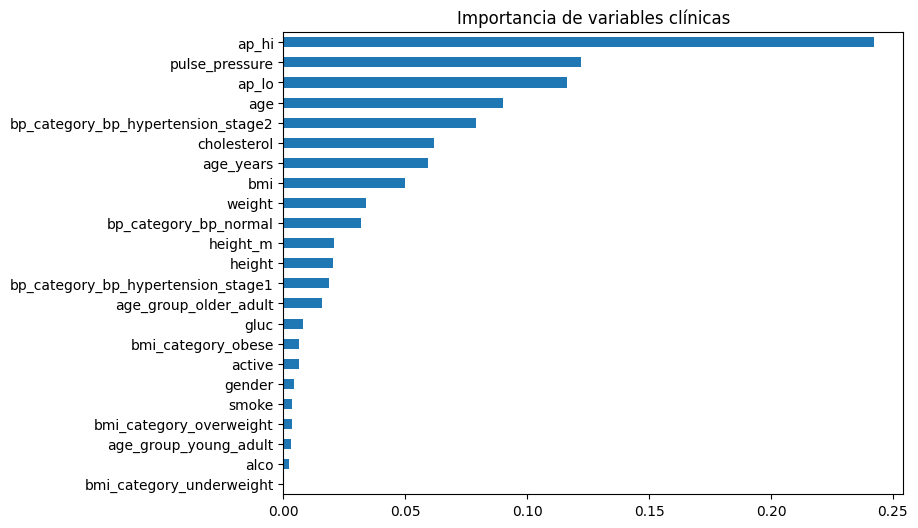

In [33]:
importances = best_rf.feature_importances_
features = X.columns

pd.Series(importances, index=features)\
    .sort_values()\
    .plot(kind="barh", figsize=(8,6))

plt.title("Importancia de variables clínicas")
plt.show()

La baja importancia relativa de la variable ‘smoking’, por ejemplo, puede deberse a su baja prevalencia en el dataset y a que su efecto está mediado por otras variables fisiológicas.

## Analisis de distintos umbrales



Se evaluó el desempeño del modelo bajo diferentes umbrales de clasificación, analizando cómo varían la sensibilidad, especificidad y precisión de las predicciones. Este análisis permite adaptar el modelo a distintos objetivos clínicos según el contexto de aplicación.

In [ ]:
for t in [0.5, 0.45, 0.4, 0.35, 0.3]:
    y_pred_t = (y_prob >= t).astype(int)
    print(f"\nUmbral = {t}")
    print(classification_report(y_test, y_pred_t))


Umbral = 0.5
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      6947
           1       0.74      0.70      0.72      6804

    accuracy                           0.73     13751
   macro avg       0.73      0.73      0.73     13751
weighted avg       0.73      0.73      0.73     13751


Umbral = 0.45
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      6947
           1       0.72      0.74      0.73      6804

    accuracy                           0.73     13751
   macro avg       0.73      0.73      0.73     13751
weighted avg       0.73      0.73      0.73     13751


Umbral = 0.4
              precision    recall  f1-score   support

           0       0.76      0.65      0.70      6947
           1       0.69      0.79      0.73      6804

    accuracy                           0.72     13751
   macro avg       0.72      0.72      0.72     13751
weighted avg       0.72      0.

In [ ]:
for t in [0.55, 0.5, 0.45, 0.4, 0.35]:
    y_pred_t = (y_prob >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred_t)

    tn, fp, fn, tp = cm.ravel()
    fallidos = fp + fn

    print(
        f"Umbral {t}: "
        f"FN = {fn}, FP = {fp}, Fallidos = {fallidos}"
    )


Umbral 0.55: FN = 2416, FP = 1291, Fallidos = 3707
Umbral 0.5: FN = 2062, FP = 1625, Fallidos = 3687
Umbral 0.45: FN = 1784, FP = 1963, Fallidos = 3747
Umbral 0.4: FN = 1453, FP = 2406, Fallidos = 3859
Umbral 0.35: FN = 1085, FP = 3048, Fallidos = 4133


Se observa que al reducir el umbral de decisión aumenta la sensibilidad del modelo, a costa de una mayor tasa de falsos positivos. Esta estrategia puede resultar adecuada en escenarios de detección temprana, donde se prioriza minimizar los falsos negativos, aun aceptando una menor precisión.

# Variaciones en hiperparametros

### A) Scoring: Se cambia de roc_auc a recall

Al priorizar el recall, se observa una variación mínima en la matriz de confusión respecto al modelo base. La cantidad de falsos negativos se reduce levemente, sin un impacto significativo en el resto de las métricas. Esto indica que, bajo esta configuración, el modelo presenta una capacidad limitada para modificar su comportamiento de detección sin cambios estructurales más profundos.

In [ ]:
rf_A = RandomForestClassifier(class_weight="balanced", random_state=42)

param_grid_A = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15],
    "min_samples_split": [20, 50],
    "min_samples_leaf": [5, 20],
    "criterion": ["gini", "entropy"]
}

grid_A = GridSearchCV(
    rf_A,
    param_grid_A,
    cv=5,
    scoring="recall",
    n_jobs=-1
)



In [ ]:
grid_A.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15], 'min_samples_leaf': [5, 20],
                         'min_samples_split': [20, 50],
                         'n_estimators': [100, 200]},
             scoring='recall')

In [ ]:
best_rf_A = grid_A.best_estimator_

y_pred_A = best_rf_A.predict(X_test)

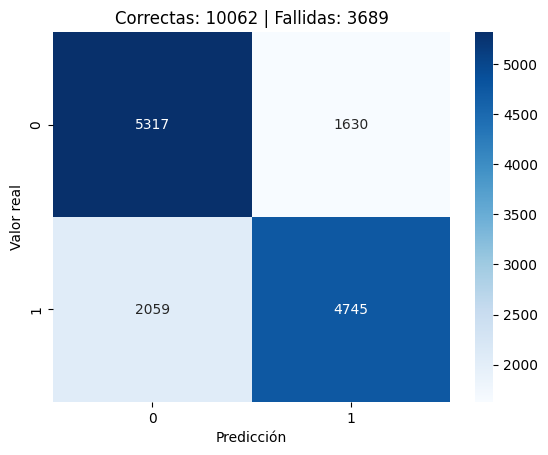

In [ ]:

cm_v2 = confusion_matrix(y_test, y_pred_A)

correctas = cm_v2[0,0] + cm_v2[1,1]
fallidas = cm_v2[0,1] + cm_v2[1,0]

sns.heatmap(cm_v2, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title(f"Matriz de confusión (RECALL) \nCorrectas: {correctas} | Fallidas: {fallidas}")
plt.show()

### B) Class weight

La incorporación de ponderación de clases produjo un cambio hacia un comportamiento más conservador del modelo. Se observa un aumento en los verdaderos negativos y una reducción en los falsos positivos, pero a costa de un incremento significativo en los falsos negativos. En este caso, la ponderación no favoreció la detección de pacientes con enfermedad cardiovascular.

In [ ]:
rf_B = RandomForestClassifier(
    class_weight={0:1, 1:2},
    random_state=42
)
param_grid_B = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15],
    "min_samples_split": [20, 50],
    "min_samples_leaf": [5, 20],
    "criterion": ["gini", "entropy"]
}

grid_B = GridSearchCV(
    rf_B,
    param_grid_B,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)




In [ ]:
grid_B.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 1, 1: 2},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15], 'min_samples_leaf': [5, 20],
                         'min_samples_split': [20, 50],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [ ]:
best_rf_B = grid_B.best_estimator_

y_pred_B = best_rf_B.predict(X_test)

In [ ]:

# Probabilidades
y_prob_B = best_rf_B.predict_proba(X_test)[:, 1]

#  Umbral (acá sí cambia)
y_pred_B_value = (y_prob_B >= 0.70).astype(int)


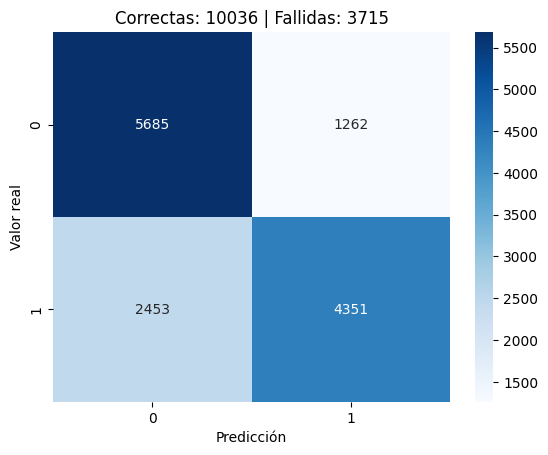

In [ ]:

cm_v3 = confusion_matrix(y_test, y_pred_B_value)

correctas = cm_v3[0,0] + cm_v3[1,1]
fallidas = cm_v3[0,1] + cm_v3[1,0]

sns.heatmap(cm_v3, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title(f"Matriz de confusión (Class Weight) \nCorrectas: {correctas} | Fallidas: {fallidas}")
plt.show()

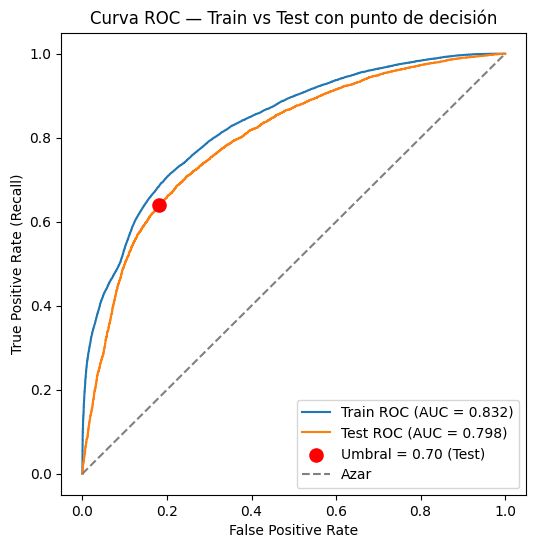

In [ ]:

# ========= ROC TRAIN =========
y_train_prob_B = best_rf_B.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob_B)
auc_train = roc_auc_score(y_train, y_train_prob_B)

# ========= ROC TEST =========
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_B)
auc_test = roc_auc_score(y_test, y_prob_B)

# ========= Punto del umbral 0.70 (TEST) =========
TN = cm_v3[0,0]
FP = cm_v3[0,1]
FN = cm_v3[1,0]
TP = cm_v3[1,1]

tpr_070 = TP / (TP + FN)   # Recall
fpr_070 = FP / (FP + TN)

# ========= PLOT =========
plt.figure(figsize=(6,6))

plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.3f})")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.3f})")

plt.scatter(
    fpr_070, tpr_070,
    color="red", s=90, zorder=5,
    label="Umbral = 0.70 (Test)"
)

plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Azar")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC — Train vs Test con punto de decisión")
plt.legend()
plt.show()


### C)Recall + Class_weight

La estrategia combinada no introduce cambios adicionales respecto al uso exclusivo de ponderación de clases. El comportamiento del modelo permanece dominado por el efecto del class_weight, manteniendo una mayor especificidad pero reduciendo la capacidad de detección de la clase positiva.

In [ ]:
rf_C = RandomForestClassifier(
    class_weight={0:1, 1:2},
    random_state=42
)
param_grid_C = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15],
    "min_samples_split": [20, 50],
    "min_samples_leaf": [5, 20],
    "criterion": ["gini", "entropy"]
}

grid_C = GridSearchCV(
    rf_C,
    param_grid_C,
    cv=5,
    scoring="recall",
    n_jobs=-1
)




In [ ]:
grid_C.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 1, 1: 2},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15], 'min_samples_leaf': [5, 20],
                         'min_samples_split': [20, 50],
                         'n_estimators': [100, 200]},
             scoring='recall')

In [ ]:
best_rf_C = grid_C.best_estimator_

y_prob_C = best_rf_C.predict_proba(X_test)[:, 1]
y_pred_C = (y_prob_C >= 0.695).astype(int)


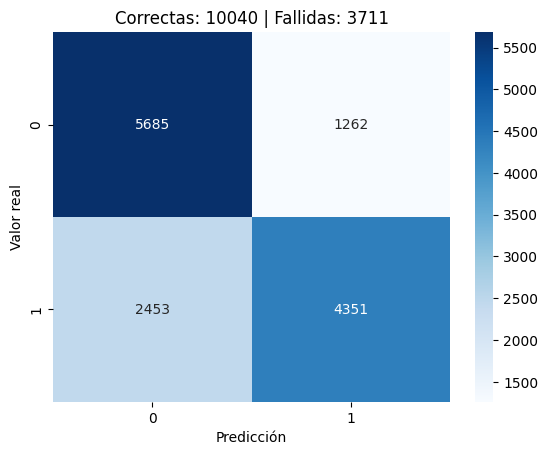

In [ ]:
cm_v4 = confusion_matrix(y_test, y_pred_C)

correctas = cm_v4[0,0] + cm_v4[1,1]
fallidas = cm_v4[0,1] + cm_v4[1,0]

sns.heatmap(cm_v3, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title(f"Matriz de confusión (RECALL + Classweight) \nCorrectas: {correctas} | Fallidas: {fallidas}")
plt.show()

Estos resultados evidencian que no todos los ajustes orientados teóricamente a mejorar la sensibilidad producen el efecto esperado en la práctica. El análisis detallado de las matrices de confusión resulta fundamental para validar si una estrategia realmente cumple con los objetivos clínicos planteados.

#Conclusión general

Los resultados obtenidos muestran que los modelos basados en Random Forest presentan un desempeño sólido y estable, aunque con limitaciones en su capacidad para modificar significativamente el balance entre sensibilidad y especificidad mediante ajustes simples de hiperparámetros. Este hallazgo refuerza la necesidad de analizar críticamente las decisiones de modelado en función del contexto de aplicación.

En futuros trabajos, se propone abordar este mismo problema utilizando arquitecturas de redes neuronales, con el objetivo de explorar modelos con mayor capacidad representacional. En particular, se buscará evaluar si enfoques basados en deep learning permiten capturar interacciones no lineales más complejas entre variables clínicas, manteniendo al mismo tiempo criterios de interpretabilidad y evaluación clínica rigurosa.

En conjunto, este proyecto sienta una base sólida para el desarrollo de modelos predictivos aplicados a salud, enfatizando la importancia del criterio clínico, la interpretabilidad y el análisis crítico de los resultados como pilares fundamentales del aprendizaje automático en contextos médicos.

# Simulador

In [49]:
model = grid.best_estimator_
columns = X_train.columns

In [55]:
def ingresar_paciente():
    return {
        "age": int(input("Edad (años): ")) * 365,
        "gender": int(input("Sexo (1=mujer, 2=hombre): ")),
        "height": int(input("Altura (cm): ")),
        "weight": float(input("Peso (kg): ")),
        "ap_hi": int(input("Presión sistólica (mmHg): ")),
        "ap_lo": int(input("Presión diastólica (mmHg): ")),
        "cholesterol": int(input("Colesterol (1=normal, 2=alto, 3=muy alto):")),
        "gluc": int(input("Glucosa (1=normal, 2=alto, 3=muy alto): ")),
        "smoke": int(input("Fuma (0=no, 1=sí): ")),
        "alco": int(input("Alcohol (0=no, 1=sí): ")),
        "active": int(input("Actividad física (0=no, 1=sí): "))
    }


In [56]:
def transformar_paciente(p):
    df = pd.DataFrame([p])

    df["age_years"] = (df["age"] / 365).astype(int)
    df["height_m"] = df["height"] / 100
    df["bmi"] = df["weight"] / (df["height_m"] ** 2)

    df["bmi_category"] = pd.cut(
        df["bmi"],
        bins=[0, 18.5, 25, 30, 100],
        labels=["underweight", "normal", "overweight", "obese"]
    )

    if df.loc[0, "ap_hi"] < 120 and df.loc[0, "ap_lo"] < 80:
        df["bp_category"] = "bp_normal"
    elif df.loc[0, "ap_hi"] < 130:
        df["bp_category"] = "bp_elevated"
    elif df.loc[0, "ap_hi"] < 140:
        df["bp_category"] = "bp_hypertension_stage1"
    else:
        df["bp_category"] = "bp_hypertension_stage2"

    return df


In [57]:
def simular():
    paciente = ingresar_paciente()
    df = transformar_paciente(paciente)

    X = pd.get_dummies(df)
    X = X.reindex(columns=columns, fill_value=0)

    prob = model.predict_proba(X)[0, 1]
    pred = model.predict(X)[0]

    print(f"\nRiesgo cardiovascular estimado: {prob*100:.1f}%")
    print("Clasificación:", "RIESGO" if pred == 1 else "BAJO RIESGO")


Se pide los datos al paciente y se genera un resultado:

In [62]:
simular()


Edad (años): 80
Sexo (1=mujer, 2=hombre): 1
Altura (cm): 155
Peso (kg): 75
Presión sistólica (mmHg): 126
Presión diastólica (mmHg): 84
Colesterol (1=normal, 2=alto, 3=muy alto):3
Glucosa (1=normal, 2=alto, 3=muy alto): 2
Fuma (0=no, 1=sí): 1
Alcohol (0=no, 1=sí): 1
Actividad física (0=no, 1=sí): 0

Riesgo cardiovascular estimado: 71.8%
Clasificación: RIESGO


In [61]:
simular()


Edad (años): 55
Sexo (1=mujer, 2=hombre): 2
Altura (cm): 180
Peso (kg): 100
Presión sistólica (mmHg): 130
Presión diastólica (mmHg): 90
Colesterol (1=normal, 2=alto, 3=muy alto):2
Glucosa (1=normal, 2=alto, 3=muy alto): 1
Fuma (0=no, 1=sí): 1
Alcohol (0=no, 1=sí): 1
Actividad física (0=no, 1=sí): 1

Riesgo cardiovascular estimado: 58.8%
Clasificación: RIESGO


In [63]:
simular()

Edad (años): 12
Sexo (1=mujer, 2=hombre): 2
Altura (cm): 140
Peso (kg): 50
Presión sistólica (mmHg): 100
Presión diastólica (mmHg): 75
Colesterol (1=normal, 2=alto, 3=muy alto):1
Glucosa (1=normal, 2=alto, 3=muy alto): 1
Fuma (0=no, 1=sí): 0
Alcohol (0=no, 1=sí): 0
Actividad física (0=no, 1=sí): 1

Riesgo cardiovascular estimado: 5.1%
Clasificación: BAJO RIESGO
